In [1]:
!pip install livelossplot tqdm pycm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.9/70.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.4/610.4 kB 9.4 MB/s eta 0:00:00


In [2]:

## Imports
import os, random
import numpy as np

#DeepLearning Torch
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.model_selection import ShuffleSplit

from livelossplot import PlotLosses
from tqdm import tqdm
from pycm import *

#matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#randomizer
def set_seed(seed):
  """
  Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  torch.backends.cudnn.benchmark = False # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. Useful when inputs do not change size
  torch.backends.cudnn.enabled = False

  return True

In [3]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

No GPU available! Running on CPU


In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler
from livelossplot import PlotLosses
from tqdm import tqdm
import matplotlib.pyplot as plt

def custom_collate_fn(batch):
    collated = {}
    for key in batch[0]:
        if key == "original_height":
            collated[key] = [sample[key] for sample in batch]
        else:
            collated[key] = default_collate([sample[key] for sample in batch])
    return collated

In [8]:
#shortest shape :5,200,24
#longest shape: 96,200,24

class Preprocessor(Dataset):
    def __init__(self, split="train", file_num=None, target='pressure_buildup',
                 normalize=True, pad_mode='zero'):

        if split == "train":
            directory = "/content/drive/MyDrive/Hackathon/train_data"
        elif split == "val":
            directory = "/content/drive/MyDrive/Hackathon/val_data"

        else:
            raise ValueError("split should be either 'train', 'val', or 'test'")

        self.file_paths = [os.path.join(directory, f)
                           for f in np.sort([f for f in os.listdir(directory) if
                                             f.endswith('.npz')])]
        if file_num is not None:
            self.file_paths = self.file_paths[:file_num]

        if target not in ["pressure_buildup", "gas_saturation"]:
            raise ValueError("target should be either 'pressure_buildup' or 'gas_saturation'")
        else:
            self.target = target
        self.normalize = normalize
        self.pad_mode = pad_mode

    def __len__(self):
        return len(self.file_paths)

    def __str__(self):
        return (f"ReservoirDataset containing {len(self)} samples.\n"
                f"Target variable: {self.target}\n"
                f"Normalization applied: {'Yes' if self.normalize else 'No'}\n"
                f"Input shape per sample: 96x200 with 24 channels\n"
                f"Target shape per sample: 96x200 with 24 time steps\n"
                f"Files are stored in: {os.path.dirname(self.file_paths[0]) if self.file_paths else 'No files found'}")

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        data = np.load(file_path)

        def normalize(x):
            mean = x.mean()
            std = x.std() if x.std() > 0 else 1.0
            return (x - mean) / std

        inputs = np.zeros((96, 200, 24), dtype=np.float32)

        inputs[:, :, 0] = self._pad_array(normalize(data['perm_r']), (96, 200))
        inputs[:, :, 1] = self._pad_array(normalize(data['perm_z']), (96, 200))
        inputs[:, :, 2] = self._pad_array(normalize(data['porosity']), (96, 200))
        perf_mask = self._create_perforation_mask(data['perf_interval'], (96, 200))
        inputs[:, :, 3] = self._pad_array(perf_mask, (96, 200))

        for i, key in enumerate(['temperature', 'Swi', 'lam', 'inj_rate']):
            const_field = np.full_like(data['porosity'], data[key])
            inputs[:, :, 4 + i] = self._pad_array(normalize(const_field), (96, 200))

        for i in range(5):
            inputs[:, :, 8 + i] = inputs[:, :, 0]  # perm_r replication
            inputs[:, :, 13 + i] = inputs[:, :, 1]  # perm_z replication
        for i in range(4):
            inputs[:, :, 18 + i] = inputs[:, :, 2]  # porosity replication
        for i in range(2):
            inputs[:, :, 22 + i] = inputs[:, :, 3]  # perf replication

        target_data = data[self.target]
        target_original = target_data.copy()
        target_array = np.zeros((96, 200, 24), dtype=np.float32)

        means = target_data.mean(axis=(0, 1))
        stds = target_data.std(axis=(0, 1))
        stds[stds == 0] = 1.0
        norm_target = (target_data - means[None, None, :]) / stds[None, None, :]

        for i in range(24):
            target_array[:, :, i] = self._pad_array(norm_target[..., i], (96, 200))

        return {
            "inputs": torch.from_numpy(inputs).permute(2, 0, 1),
            "target": torch.from_numpy(target_array).permute(2, 0, 1),
            "original_height": target_data.shape[0],
            "original_target": torch.from_numpy(target_original).permute(2, 0, 1).float(),
            "mean": torch.from_numpy(means).float(),
            "std": torch.from_numpy(stds).float()
        }

    def _normalize_data(self, array):
        mean = array.mean()
        std = array.std()
        if std > 0:
            return (array - mean) / std
        return array - mean

    def _pad_array(self, array, target_shape):
        pad_width = [(0, max(0, target - array.shape[i])) for i, target in enumerate(target_shape)]
        if self.pad_mode == "zero":
            return np.pad(array, pad_width, mode='constant', constant_values=0)
        elif self.pad_mode == "mean":
            original_mean = np.mean(array)
            return np.pad(array, pad_width, mode='constant', constant_values=original_mean)
        else:
            raise ValueError("pad_mode should be either 'zero' or 'mean'")

    def _create_perforation_mask(self, perf_interval, shape):
        mask = np.zeros(shape, dtype=np.float32)
        z_start, z_end = perf_interval
        mask[z_start:z_end, :50] = 1
        return mask



In [9]:
ds = Preprocessor("train", file_num=10)
for i in range(len(ds)):
    assert ds[i]["inputs"].shape == (24, 96, 200), f"❌ Bad shape at index {i}"
print("✅ All inputs are padded to (24, 96, 200)")

✅ All inputs are padded to (24, 96, 200)


In [10]:
train_data = Preprocessor(split="train", file_num=100, target='pressure_buildup', pad_mode="zero")
print(train_data)

ReservoirDataset containing 100 samples.
Target variable: pressure_buildup
Normalization applied: Yes
Input shape per sample: 96x200 with 24 channels
Target shape per sample: 96x200 with 24 time steps
Files are stored in: /content/drive/MyDrive/Hackathon/train_data


In [11]:
# Load the raw data from the first file
import numpy as np
npz_path = train_data.file_paths[0]
raw_data = np.load(npz_path)

porosity = raw_data['porosity']
perm_r = raw_data['perm_r']
perm_z = raw_data['perm_z']
perf_interval = raw_data['perf_interval']
temperature = np.full_like(porosity, raw_data['temperature'])
gas_saturation = raw_data['gas_saturation'][:, :, -1]  # last time step

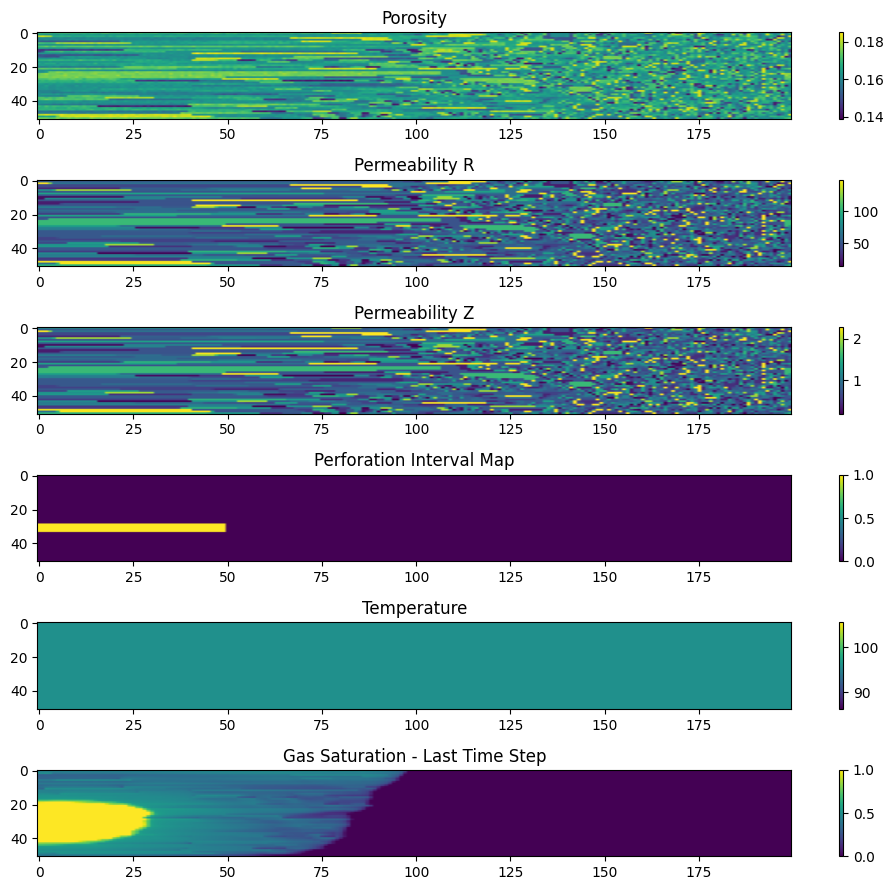

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 9))

plt.subplot(6, 1, 1)
plt.imshow(porosity, aspect='auto')
plt.colorbar()
plt.title('Porosity')

plt.subplot(6, 1, 2)
plt.imshow(perm_r, aspect='auto')
plt.colorbar()
plt.title('Permeability R')

plt.subplot(6, 1, 3)
plt.imshow(perm_z, aspect='auto')
plt.colorbar()
plt.title('Permeability Z')

plt.subplot(6, 1, 4)
# Create a mask image for the perf_interval
perf_mask = np.zeros_like(porosity)
z_start, z_end = perf_interval
perf_mask[z_start:z_end, :50] = 1
plt.imshow(perf_mask, aspect='auto')
plt.colorbar()
plt.title('Perforation Interval Map')

plt.subplot(6, 1, 5)
plt.imshow(temperature, aspect='auto')
plt.colorbar()
plt.title('Temperature')

plt.subplot(6, 1, 6)
plt.imshow(gas_saturation, aspect='auto')
plt.colorbar()
plt.title('Gas Saturation - Last Time Step')

plt.tight_layout()
plt.show()


In [16]:
sg_dataset = Preprocessor(split="train", file_num=1000, target='gas_saturation', pad_mode="zero")
pb_dataset = Preprocessor(split="train", file_num=1000, target='pressure_buildup', pad_mode="zero")

ss = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, val_idx = next(ss.split(range(len(sg_dataset))))

sg_train_dataset = Subset(sg_dataset, train_idx)
sg_val_dataset = Subset(sg_dataset, val_idx)

pb_train_dataset = Subset(pb_dataset, train_idx)
pb_val_dataset = Subset(pb_dataset, val_idx)

len(sg_train_dataset), len(sg_val_dataset), len(pb_train_dataset), len(pb_val_dataset)

(900, 100, 900, 100)

In [17]:
def custom_collate_fn(batch):
    collated = {}
    for key in batch[0]:
        if key in ["original_height", "original_target"]:
            collated[key] = [sample[key] for sample in batch]  # ⛔ Do NOT stack
        else:
            collated[key] = default_collate([sample[key] for sample in batch])  # ✅ Do stack
    return collated


In [18]:
train_dataset = Preprocessor(split="train", file_num=1000)
val_dataset = Preprocessor(split="val", file_num=200)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=custom_collate_fn)


In [19]:
train_loader = DataLoader(
    train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn
)


In [20]:
batch = next(iter(train_loader))
print(batch['inputs'].shape)          # ✅ (8, 24, 96, 200)
print(len(batch['original_height']))  # ✅ 8

torch.Size([8, 24, 96, 200])
8


In [26]:
# Define a simple multi-layer CNN model
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.skip(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return self.relu(out)

class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        attn = torch.cat([avg_pool, max_pool], dim=1)
        attn = torch.sigmoid(self.conv(attn))
        return x * attn

class Reservoir2DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(24, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.resblock1 = ResidualBlock(64, 128)
        self.resblock2 = ResidualBlock(128, 128)
        self.attn = SpatialAttention()
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 24, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.attn(x)
        return self.decoder(x)


class TemporalSmoothnessLoss(nn.Module):
    def __init__(self):
        super(TemporalSmoothnessLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, predicted, target):
        loss = self.mse_loss(predicted, target)

        # Encourage temporal smoothness
        temporal_diff = torch.abs(predicted[:, :, 1:] - predicted[:, :, :-1])
        temporal_target_diff = torch.abs(target[:, :, 1:] - target[:, :, :-1])
        smoothness_loss = self.mse_loss(temporal_diff, temporal_target_diff)

        return loss + 0.1 * smoothness_loss  # You can tune the weighting factor

# Instantiate and test the model
model = Reservoir2DCNN()
x = torch.randn(1, 24, 96, 200)
y = model(x)
print(y.shape)  # Should be torch.Size([1, 24, 96, 200])



torch.Size([1, 24, 96, 200])


In [27]:
import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader
import numpy as np
import random

# --- Set Seed for Reproducibility ---
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed = 42
set_seed(seed)

# --- Hyperparameters ---
num_channels = 24
num_classes = 24
lr = 1e-5
weight_decay = 1e-5
batch_size = 32
n_epochs = 100

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load Dataset ---
train_dataset = Preprocessor(split="train", file_num=1000, target="pressure_buildup", normalize=True)
val_dataset = Preprocessor(split="val", file_num=200, target="pressure_buildup", normalize=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

# --- CNN Model ---
model = Reservoir2DCNN().to(device)

# --- Loss & Optimizer ---
criterion = TemporalSmoothnessLoss()
optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# --- R² Metric ---
def r2_score(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2


In [28]:
model_path = "/content/drive/MyDrive/Hackathon/models"
logs_path = "/content/drive/MyDrive/Hackathon/models"

def train(model, optimizer, criterion, data_loader, device):
    model.train()
    train_loss = 0.
    r2_accumulator = 0.

    for batch in data_loader:
        inputs = batch["inputs"].to(device)
        targets = batch["target"].to(device)
        original_heights = batch["original_height"]

        optimizer.zero_grad()
        outputs = model(inputs)

        batch_loss = 0
        batch_r2 = 0

        for i in range(inputs.size(0)):
            h = original_heights[i]
            pred_cropped = outputs[i][:, :h, :].unsqueeze(0)
            target_cropped = targets[i][:, :h, :].unsqueeze(0)

            loss = criterion(pred_cropped, target_cropped)
            batch_loss += loss
            batch_r2 += r2_score(pred_cropped, target_cropped)

        batch_loss /= inputs.size(0)
        batch_r2 /= inputs.size(0)
        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss.item() * inputs.size(0)
        r2_accumulator += batch_r2.item() * inputs.size(0)

    return train_loss / len(data_loader.dataset), r2_accumulator / len(data_loader.dataset)

def valid(model, criterion, data_loader, device):
    model.eval()
    valid_loss = 0.
    r2_accumulator = 0.

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch["inputs"].to(device)
            targets = batch["target"].to(device)
            original_heights = batch["original_height"]

            outputs = model(inputs)

            batch_loss = 0
            batch_r2 = 0

            for i in range(inputs.size(0)):
                h = original_heights[i]
                pred_cropped = outputs[i][:, :h, :].unsqueeze(0)
                target_cropped = targets[i][:, :h, :].unsqueeze(0)

                loss = criterion(pred_cropped, target_cropped)
                batch_loss += loss
                batch_r2 += r2_score(pred_cropped, target_cropped)

            batch_loss /= inputs.size(0)
            batch_r2 /= inputs.size(0)
            valid_loss += batch_loss.item() * inputs.size(0)
            r2_accumulator += batch_r2.item() * inputs.size(0)

    return valid_loss / len(data_loader.dataset), r2_accumulator / len(data_loader.dataset)


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


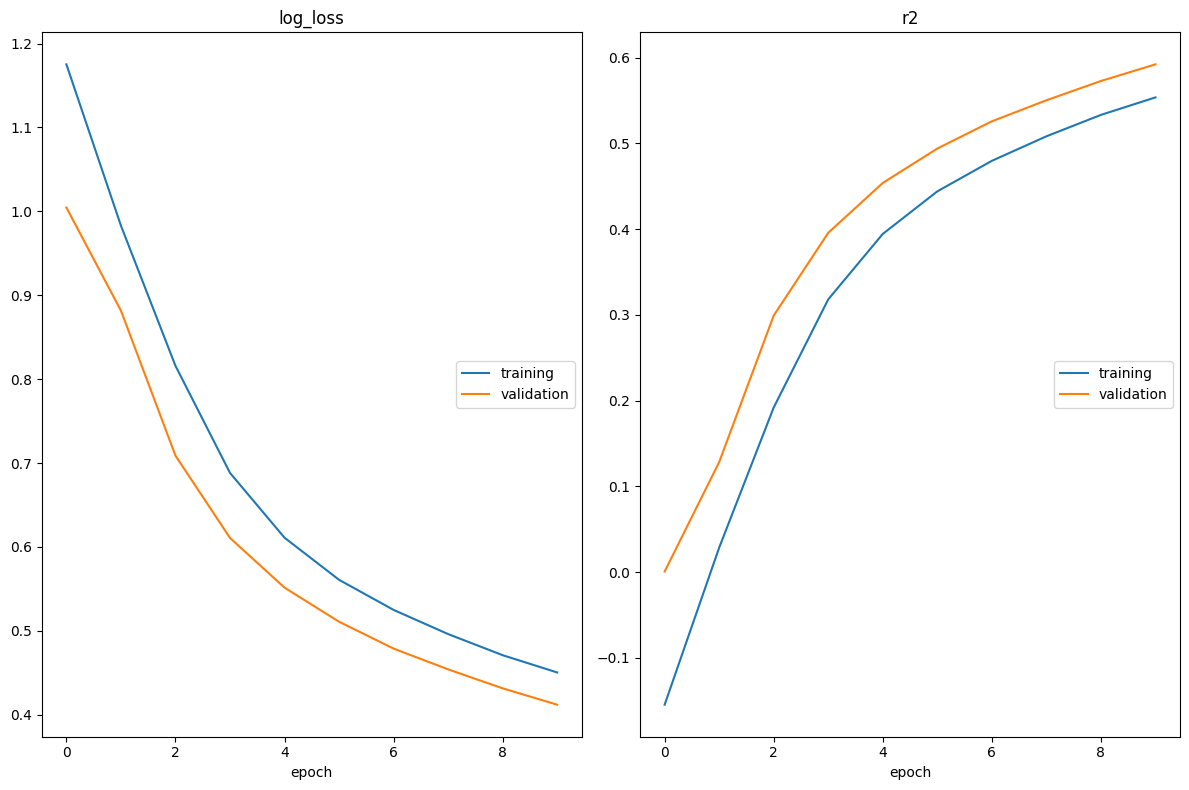

100%|██████████| 10/10 [5:32:26<00:00, 1994.64s/it]

log_loss
	training         	 (min:    0.450, max:    1.175, cur:    0.450)
	validation       	 (min:    0.412, max:    1.005, cur:    0.412)
r2
	training         	 (min:   -0.155, max:    0.553, cur:    0.553)
	validation       	 (min:    0.001, max:    0.592, cur:    0.592)


In [29]:
from livelossplot import PlotLosses
from tqdm import tqdm
import torch

# --- Training Loop with Early Stopping ---
patience = 10
best_r2 = -float('inf')
patience_counter = 0

model_path = "/content/drive/MyDrive/Hackathon/models"
checkpoint_name = "pb_trainonall_CNN.pth"

liveloss = PlotLosses()

for epoch in tqdm(range(10)):
    logs = {}

    # Training
    train_loss, train_r2 = train(model, optimizer, criterion, train_loader, device)
    logs['log_loss'] = train_loss
    logs['r2'] = train_r2

    # Validation
    val_loss, val_r2 = valid(model, criterion, val_loader, device)
    logs['val_log_loss'] = val_loss
    logs['val_r2'] = val_r2

    # Adjust learning rate
    scheduler.step(val_loss)

    # Check for improvement
    if val_r2 > best_r2:
        best_r2 = val_r2
        torch.save(model.state_dict(), model_path + checkpoint_name)
        patience_counter = 0
        print(f"✅ Model saved at epoch {epoch}")
    else:
        patience_counter += 1
        print(f"⏳ Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(f"⏹️ Early stopping: patience limit reached after {epoch + 1} epochs")
            break

    # Update live loss
    liveloss.update(logs)
    liveloss.send()


ReservoirDataset containing 1000 samples.
Target variable: pressure_buildup
Normalization applied: Yes
Input shape per sample: 96x200 with 24 channels
Target shape per sample: 96x200 with 24 time steps
Files are stored in: /content/drive/MyDrive/Hackathon/train_data
tensor([86])
tensor([14])


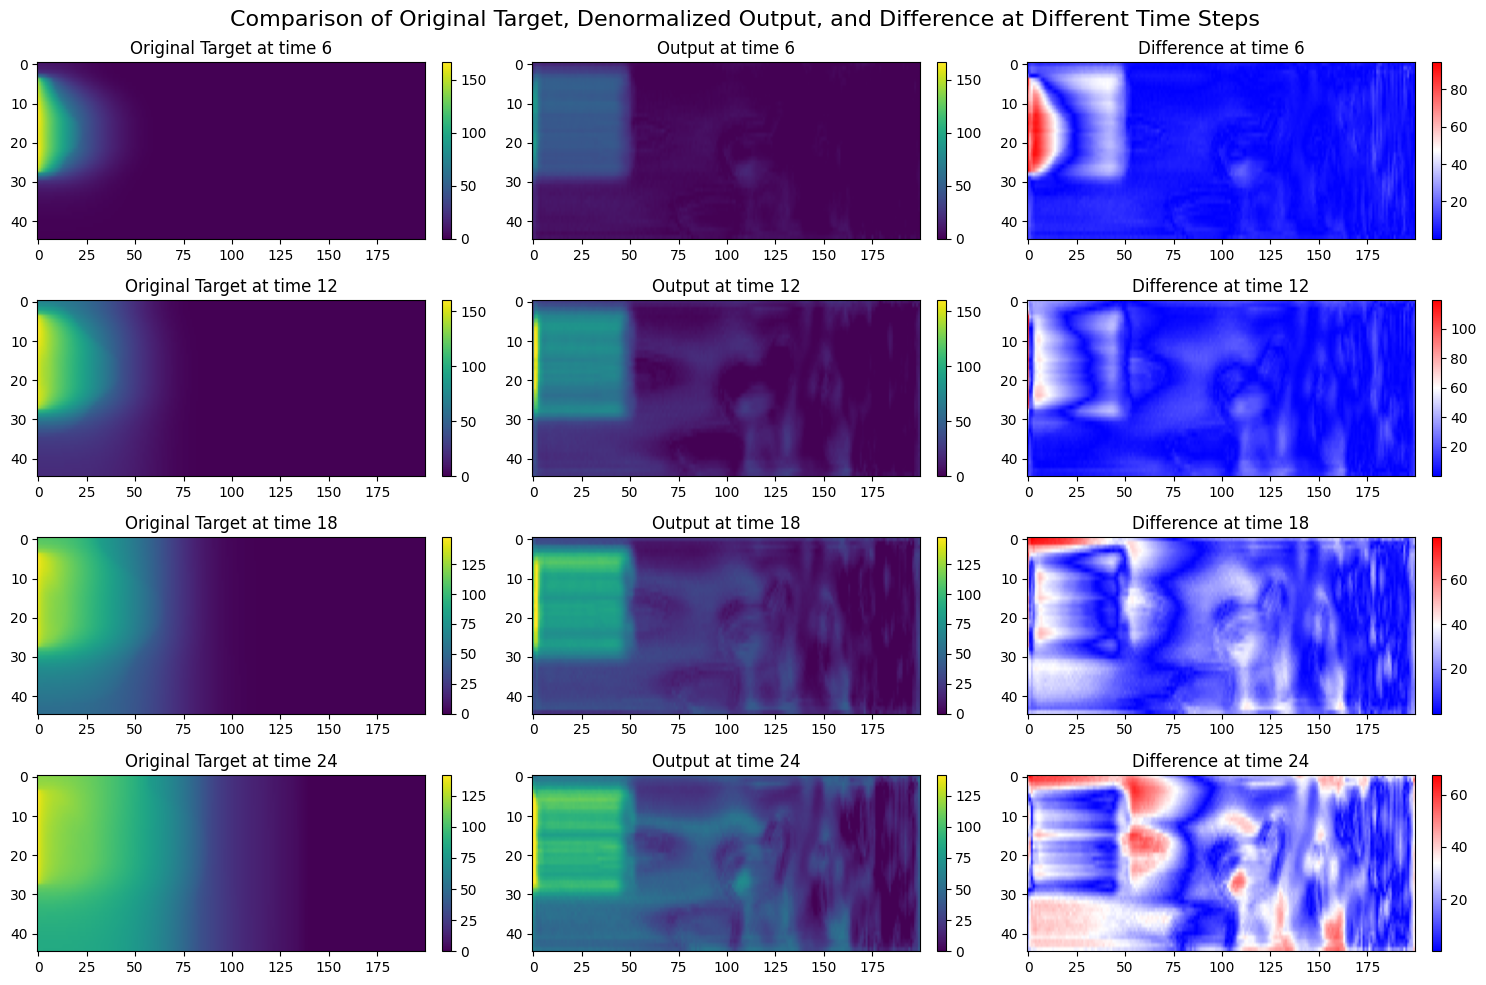

In [43]:
train_data = Preprocessor(split="train", file_num=1000, target='pressure_buildup', pad_mode="zero")
print(train_data)

sample_loader = DataLoader(train_data, batch_size=1, shuffle=True)

for data in sample_loader:
    inputs = data["inputs"].numpy()
    target = data["target"].numpy()
    print(data["original_height"])
    break

porosity = inputs[0, 2, :, :]
perm_r = inputs[0, 0, :, :]
perm_z = inputs[0, 1, :, :]
perf_interval = inputs[0, 3, :, :]
temperature = inputs[0, 4, :, :]
gas_saturation = target[0, -1, :, :]

sample_loader = DataLoader(train_data, batch_size=1, shuffle=True)

for data in sample_loader:
    inputs = data["inputs"].numpy()
    target = data["target"].numpy()
    print(data["original_height"])
    break

porosity = inputs[0, 2, :, :]
perm_r = inputs[0, 0, :, :]
perm_z = inputs[0, 1, :, :]
perf_interval = inputs[0, 3, :, :]
temperature = inputs[0, 4, :, :]
gas_saturation = target[0, -1, :, :]
model.load_state_dict(torch.load('/content/drive/MyDrive/Hackathon/modelspb_trainonall_CNN.pth'))
model.to(device)

sample_data = next(iter(sample_loader))
sample_input, sample_target = sample_data["inputs"].to(device), sample_data["target"].to(device)

with torch.no_grad():
    model.eval()
    sample_output = model(sample_input)

height = sample_data["original_height"].item()
original_target = sample_data["original_target"][0, :, :height, :].cpu().numpy()
means = original_target.mean(axis=(1, 2))
stds = original_target.std(axis=(1, 2))

# Denormalize output
def denormalize(normalized_data, mean, std):
    """Reverses the normalization process."""
    return normalized_data * std + mean

output_denormalized = torch.zeros_like(sample_output[0, :, :height, :])
for i in range(output_denormalized.shape[0]):
    output_denormalized[i] = denormalize(sample_output[0, i, :height, :].cpu(), means[i], stds[i])

time_steps = [6, 12, 18, 24]
indices = [step - 1 for step in time_steps]  # Convert to zero-based index

# Set ncols to 3 to include the difference plots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
fig.suptitle('Comparison of Original Target, Denormalized Output, and Difference at Different Time Steps', fontsize=16)

for i, index in enumerate(indices):
    target_img = original_target[index]
    output_img = output_denormalized[index].cpu().detach().numpy()

    # Plot original target
    ax = axes[i, 0]
    im_target = ax.imshow(target_img, aspect='auto', vmin=0, vmax=target_img.max())
    ax.set_title(f'Original Target at time {time_steps[i]}')
    fig.colorbar(im_target, ax=ax, fraction=0.046, pad=0.04)

    # Plot denormalized output
    ax = axes[i, 1]
    im_output = ax.imshow(output_img, aspect='auto', vmin=0, vmax=target_img.max())
    ax.set_title(f'Output at time {time_steps[i]}')
    fig.colorbar(im_output, ax=ax, fraction=0.046, pad=0.04)

    # Plot difference
    ax = axes[i, 2]
    im_diff = ax.imshow(np.abs(target_img - output_img), aspect='auto', cmap='bwr')
    ax.set_title(f'Difference at time {time_steps[i]}')
    fig.colorbar(im_diff, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [34]:

def r2(x, y):
    x = x.flatten()
    y = y.flatten()
    zx = (x-np.mean(x))/np.std(x, ddof=1)
    zy = (y-np.mean(y))/np.std(y, ddof=1)
    r = np.sum(zx*zy)/(len(x)-1)
    return r**2

def MAE(x, y):
    x = x.flatten()
    y = y.flatten()
    return np.mean(np.abs(x - y))

def denormalize(normalized_data, mean, std):
    """Reverses the normalization process."""
    return normalized_data * std + mean

In [41]:

pb_val_dataset = Preprocessor(split="val", target='pressure_buildup', pad_mode='zero')
len(pb_val_dataset)


450

In [44]:
pressure_buildup_r2 = []
pressure_buildup_MAE = []

# Iterate through all samples in the validation dataset
for idx in range(len(pb_val_dataset)):
    file_index = idx + 3600  # adjust to match the actual filename index

    with np.load(f'drive/MyDrive/Hackathon/val_data/data_{str(file_index).zfill(4)}.npz') as data:
        pressure_buildup = data['pressure_buildup']

    input_data = pb_val_dataset[idx]["inputs"].to(device)
    height = pb_val_dataset[idx]["original_height"]
    original_target = pb_val_dataset[idx]["original_target"]

    means = original_target.mean(axis=(1, 2))
    stds = original_target.std(axis=(1, 2))
    stds[stds == 0] = 1.0

    with torch.no_grad():
        model.eval()
        sample_output = model(input_data.unsqueeze(0))

    output_denormalized = torch.zeros_like(sample_output[0, :, :height, :]).to(device)
    for i in range(output_denormalized.shape[0]):
        output_denormalized[i] = denormalize(sample_output[0, i, :height, :], means[i], stds[i])

    output_denormalized = output_denormalized.permute(1, 2, 0).cpu().numpy()

    pressure_buildup = pressure_buildup[:height, :, :]  # crop to match model output
    if pressure_buildup.shape != output_denormalized.shape:
        print(f"[SKIP] Shape mismatch at idx {idx}: {pressure_buildup.shape} vs {output_denormalized.shape}")
        continue

    y_true_flat = pressure_buildup.reshape(-1)
    y_pred_flat = output_denormalized.reshape(-1)

    pressure_buildup_r2.append(r2(y_true_flat, y_pred_flat))
    pressure_buildup_MAE.append(MAE(y_true_flat, y_pred_flat))

print('--------------')
print(f'Average validation set pressure buildup R2 score is: {np.mean(pressure_buildup_r2):.4f}')
print(f'Average validation set pressure buildup MAE is: {np.mean(pressure_buildup_MAE):.4f}')
print('--------------')


--------------
Average validation set pressure buildup R2 score is: 0.6746
Average validation set pressure buildup MAE is: 6.9542
--------------
